In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import plotly.express as px
import osmnx as ox
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from itertools import cycle
import matplotlib.cm as cm
from scipy.spatial import Voronoi
from shapely import geometry, ops
import geopandas as gpd
from shapely.geometry import Polygon

def bbox_maker(lat0, lat1, long0,long1):
    return Polygon([[long0, lat0],
                    [long1,lat0],
                    [long1,lat1],
                    [long0, lat1]])

def Voronoi_polys(bbox_bounds, centers, plot = False, G = None):
    bound = geometry.box(*bbox_bounds).buffer(1).envelope.boundary
    boundarypoints = [bound.interpolate(distance=d) for d in np.arange(0, np.ceil(bound.length).astype(float), 0.01)]
    boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])
    all_coords = np.concatenate((boundarycoords, [[i[1],i[0]] for i in centers])) #Create an array of all points on the boundary and inside the polygon
    vor = Voronoi(points=all_coords)
    lines = [geometry.LineString(vor.vertices[line]) for line in 
        vor.ridge_vertices if -1 not in line]

    polys = ops.polygonize(lines)
    voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:4326")

    polydf = gpd.GeoDataFrame(geometry=[geometry.box(*bbox_bounds)], crs="epsg:4326")
    points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=centers[:,1], y=centers[:,0], crs="epsg:4326"))

    result = gpd.overlay(df1=voronois, df2=polydf, how="intersection")
    if plot and G != None:
        if plot and G == None:
            print("Missing the graph to plot.")
            return result
        fig, ax = plt.subplots(figsize=(15, 15))
        polydf.boundary.plot(ax=ax, edgecolor="blue", linewidth=6)
        ox.plot_graph(G, ax = ax, node_color = 'k', show = False, close = False)
        result.plot(ax=ax, color="red", alpha=0.3, edgecolor="black")
        points.plot(ax=ax, color="maroon")
    return result

In [2]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [3]:
city_list_full = ["São Paulo", # 0
                  "Rio de Janeiro", # 1
                  "Atlanta", # 2
                  "Manhattan", # 3
                  "Barcelona", # 4
                  "Madrid", # 5
                  "Buenos Aires", # 6 
                  "London", # 7
                  "Beijing", # 8
                  "Paris", # 9
                  "Cardiff", # 10
                  "Berlin", # 11
                  "Amsterdam", # 12
                  "São José dos Campos", # 13
                  "Los Angeles", # 14
                  "Wichita", # 15
                  "Tolouse", # 16
                  "Salt Lake", # 17
                  ]

city = city_list_full[0]

# dist = 4000
# categories = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'residential', 'other']
# categories.reverse()
categories = ["C", "B", "A"]
# G = ox.graph_from_point(latlong, dist = dist, truncate_by_edge = True, network_type="drive")

group1 = ['motorway', 'motorway_link', 'trunk', 'trunk_link']
group2 = ['primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link']
group3 = ['residential', 'other']

In [4]:
nodes, edges = pd.read_csv(f"./Results/csv/{city}_nodes.csv", index_col =[0]), pd.read_csv(f"./Results/csv/{city}_edges.csv", index_col = [0,1,2], encoding = 'latin-1')
edges = edges[edges["Cost of returning"] != 0]
edges = edges[~edges["Cost of returning"].isna()]
edges["highway"] = edges.highway.map(lambda x: x[0] if isinstance(x, list) else x)
others = ["crossing", "living_street", "unclassified", "disused", "busway", "escape", "road"]
edges["highway"] = edges.highway.map(lambda x: "other" if x  in others else x)
edges["Groups"] = edges.highway

edges["Groups"] = edges.Groups.map(lambda x: 'A' if x  in group1 else x)
edges["Groups"] = edges.Groups.map(lambda x: 'B' if x  in group2 else x)
edges["Groups"] = edges.Groups.map(lambda x: 'C' if x  in group3 else x)


# edges["Cost of returning"] = edges[q"Cost of returning"].fillna(0)
s = gpd.GeoSeries.from_wkt(nodes.geometry)
nodes = gpd.GeoDataFrame(data = nodes, geometry = s)
nodes = nodes.set_crs('epsg:4326', allow_override=True)
s = gpd.GeoSeries.from_wkt(edges.geometry)
edges = gpd.GeoDataFrame(data = edges, geometry = s)
edges = edges.set_crs('epsg:4326', allow_override=True)

G = ox.graph_from_gdfs(nodes, edges)
H = nx.MultiDiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))
H.graph["crs"] = G.graph["crs"]
print(G)

MultiDiGraph with 6470 nodes and 12783 edges


In [5]:
biggest = []
for i in nx.strongly_connected_components(G):
    biggest.append(len(i))
max(biggest)/G.number_of_nodes()

1.0

In [6]:
fig = px.box(edges, x = "Groups", y = "Cost of returning", title = city, labels = {"Cost of returning" : "Cost of return"})
fig.update_xaxes(categoryorder='array', categoryarray=['C','B','A'])
fig.update_traces(boxmean=True)
fig.update_layout(    font=dict(
        size=25,
        color="black"),
        showlegend=False
        )
fig.write_image(f"./Results/{city}_box_classes.pdf", width=1000, height=1000)
fig

In [7]:
fig = px.histogram(edges, x = "Cost of returning")
fig

In [8]:
hwy_color = {'motorway': 'red',
             'motorway_link': 'firebrick',
             'trunk': 'orange',
             'trunk_link': 'orange',
             'primary': 'gold',
             'primary_link': 'olive',
             'secondary': 'green',
             'secondary_link' : 'green',
             'tertiary': 'green',
             'tertiary_link': 'green',
             'residential': 'blue',
             'other': 'k',
             }
teste = edges.map(lambda x: x[0] if isinstance(x, list) else x)
ec = teste.replace(hwy_color).highway

patches = []
for i in hwy_color:
    patches.append(mpatches.Patch(color= hwy_color[i], label=i))

In [9]:
# hwy_width = {'motorway': 6,
#              'motorway_link': 6,
#              'trunk': 5,
#              'trunk_link': 5,
#              'primary': 4,
#              'primary_link': 4,
#              'secondary': 4,
#              'secondary_link' : 4,
#              'tertiary': 4,
#              'tertiary_link': 4,
#              'residential': 3,
#              'crossing': 3,
#              'living_street': 3,
#              'unclassified': 3,
#              'disused': 3,
#              'busway': 3}
# teste = edges.map(lambda x: x[0] if isinstance(x, list) else x)
# ew = teste.replace(hwy_width).highway

# import matplotlib.patches as mpatches
# # patches = []
# # for i in hwy_color:
# #     patches.append(mpatches.Patch(color= hwy_color[i], label=i))

In [10]:
# fig, ax = ox.plot_graph(
#     H, bgcolor="w", node_color='k', node_size=10, figsize = (20,20), show = False, close = False
# )
# fig.savefig(f"{city}.png",  bbox_inches='tight')
# edges.loc[25777974,5588633745,0].geometry.centroid, edges.loc[133491023, 1420099953, 0].geometry.centroid, edges.loc[248110880,248110883,0].geometry.centroid]

In [11]:
a = []
x = []
y = []
types = ["motorway", "trunk", "primary", "secondary", "tertiary", "residential"]
letters = ["A", "B", "C", "D", "E", "F", "G"]
for i in types:
    a.append(edges[edges.highway == i].sort_values(by = "Cost of returning", ascending=False).iloc[0]["Cost of returning"])
    x.append(edges[edges.highway == i].sort_values(by = "Cost of returning", ascending=False).iloc[0].geometry.centroid.x)
    y.append(edges[edges.highway == i].sort_values(by = "Cost of returning", ascending=False).iloc[0].geometry.centroid.y)

df_top_values = pd.DataFrame(index = types)
df_top_values['COR'] = a
df_top_values['x'] = x 
df_top_values['y'] = y
df_top_values = df_top_values.sort_values(by = "COR", ascending=False)

Group C: 53.993585230384106%
Group B: 41.43784714073379%
Group A: 4.568567628882109%


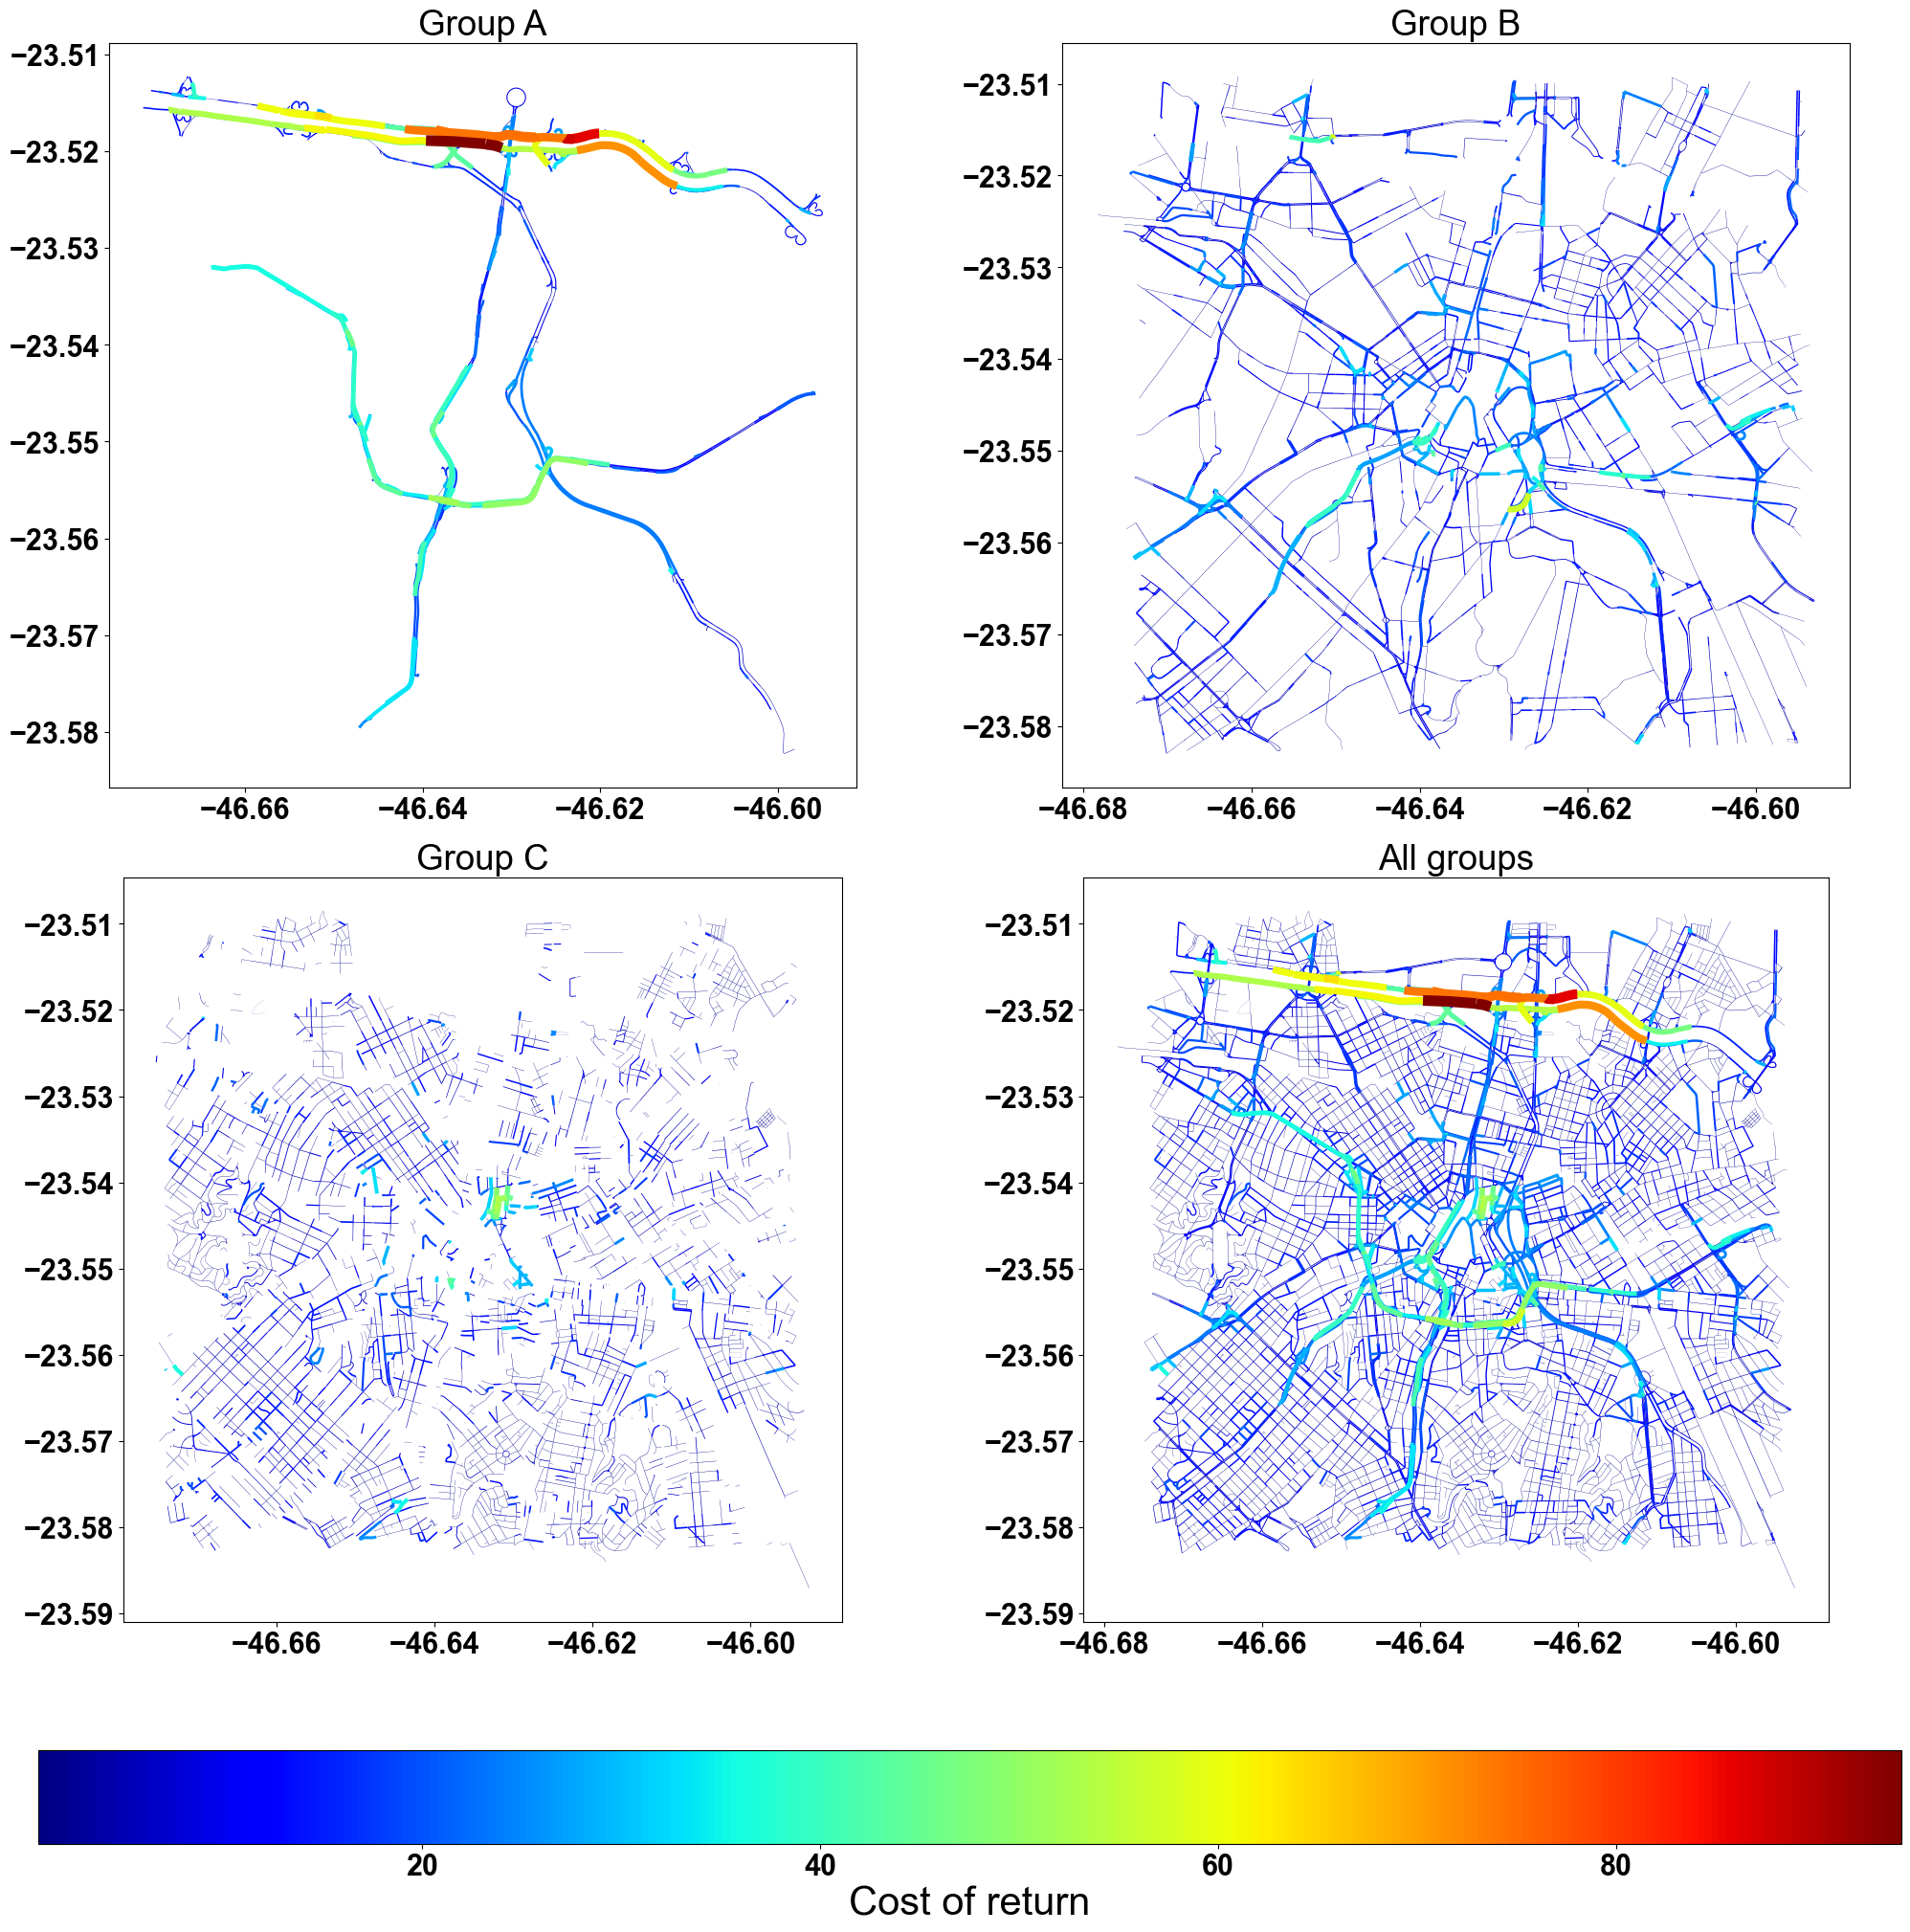

In [12]:
vmin = min(edges["Cost of returning"])
vmax = max(edges["Cost of returning"])
cmap=plt.cm.jet
fig, axs = plt.subplots(2, 2, figsize = (20,20), constrained_layout=True)
for group,ax in zip(['C','B','A',],[axs[1,0],axs[0,1], axs[0,0]]):
    edges_group = edges[edges["Groups"] == group].sort_values(by = "Cost of returning", ascending=True)
    edges_group.plot(ax = ax, column = "Cost of returning", cmap = cmap, vmin = vmin, vmax = vmax, linewidth = edges_group["Cost of returning"]/vmax*8)
    print(f"Group {group}: {100*len(edges_group)/len(edges)}%")
    ax.set_title(f'Group {group}')
edges.sort_values(by = "Cost of returning", ascending=True).plot(ax = axs[1,1], column = "Cost of returning", cmap = cmap, linewidth = edges["Cost of returning"].sort_values(ascending=True)/vmax*8)
axs[1,1].set_title(f'All groups')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax = axs[:], orientation='horizontal', label = "Cost of return")
cbar.set_label(label='Cost of return', size = 30)
plt.savefig(f"Results/{city}_COR_groups.pdf")
plt.show()

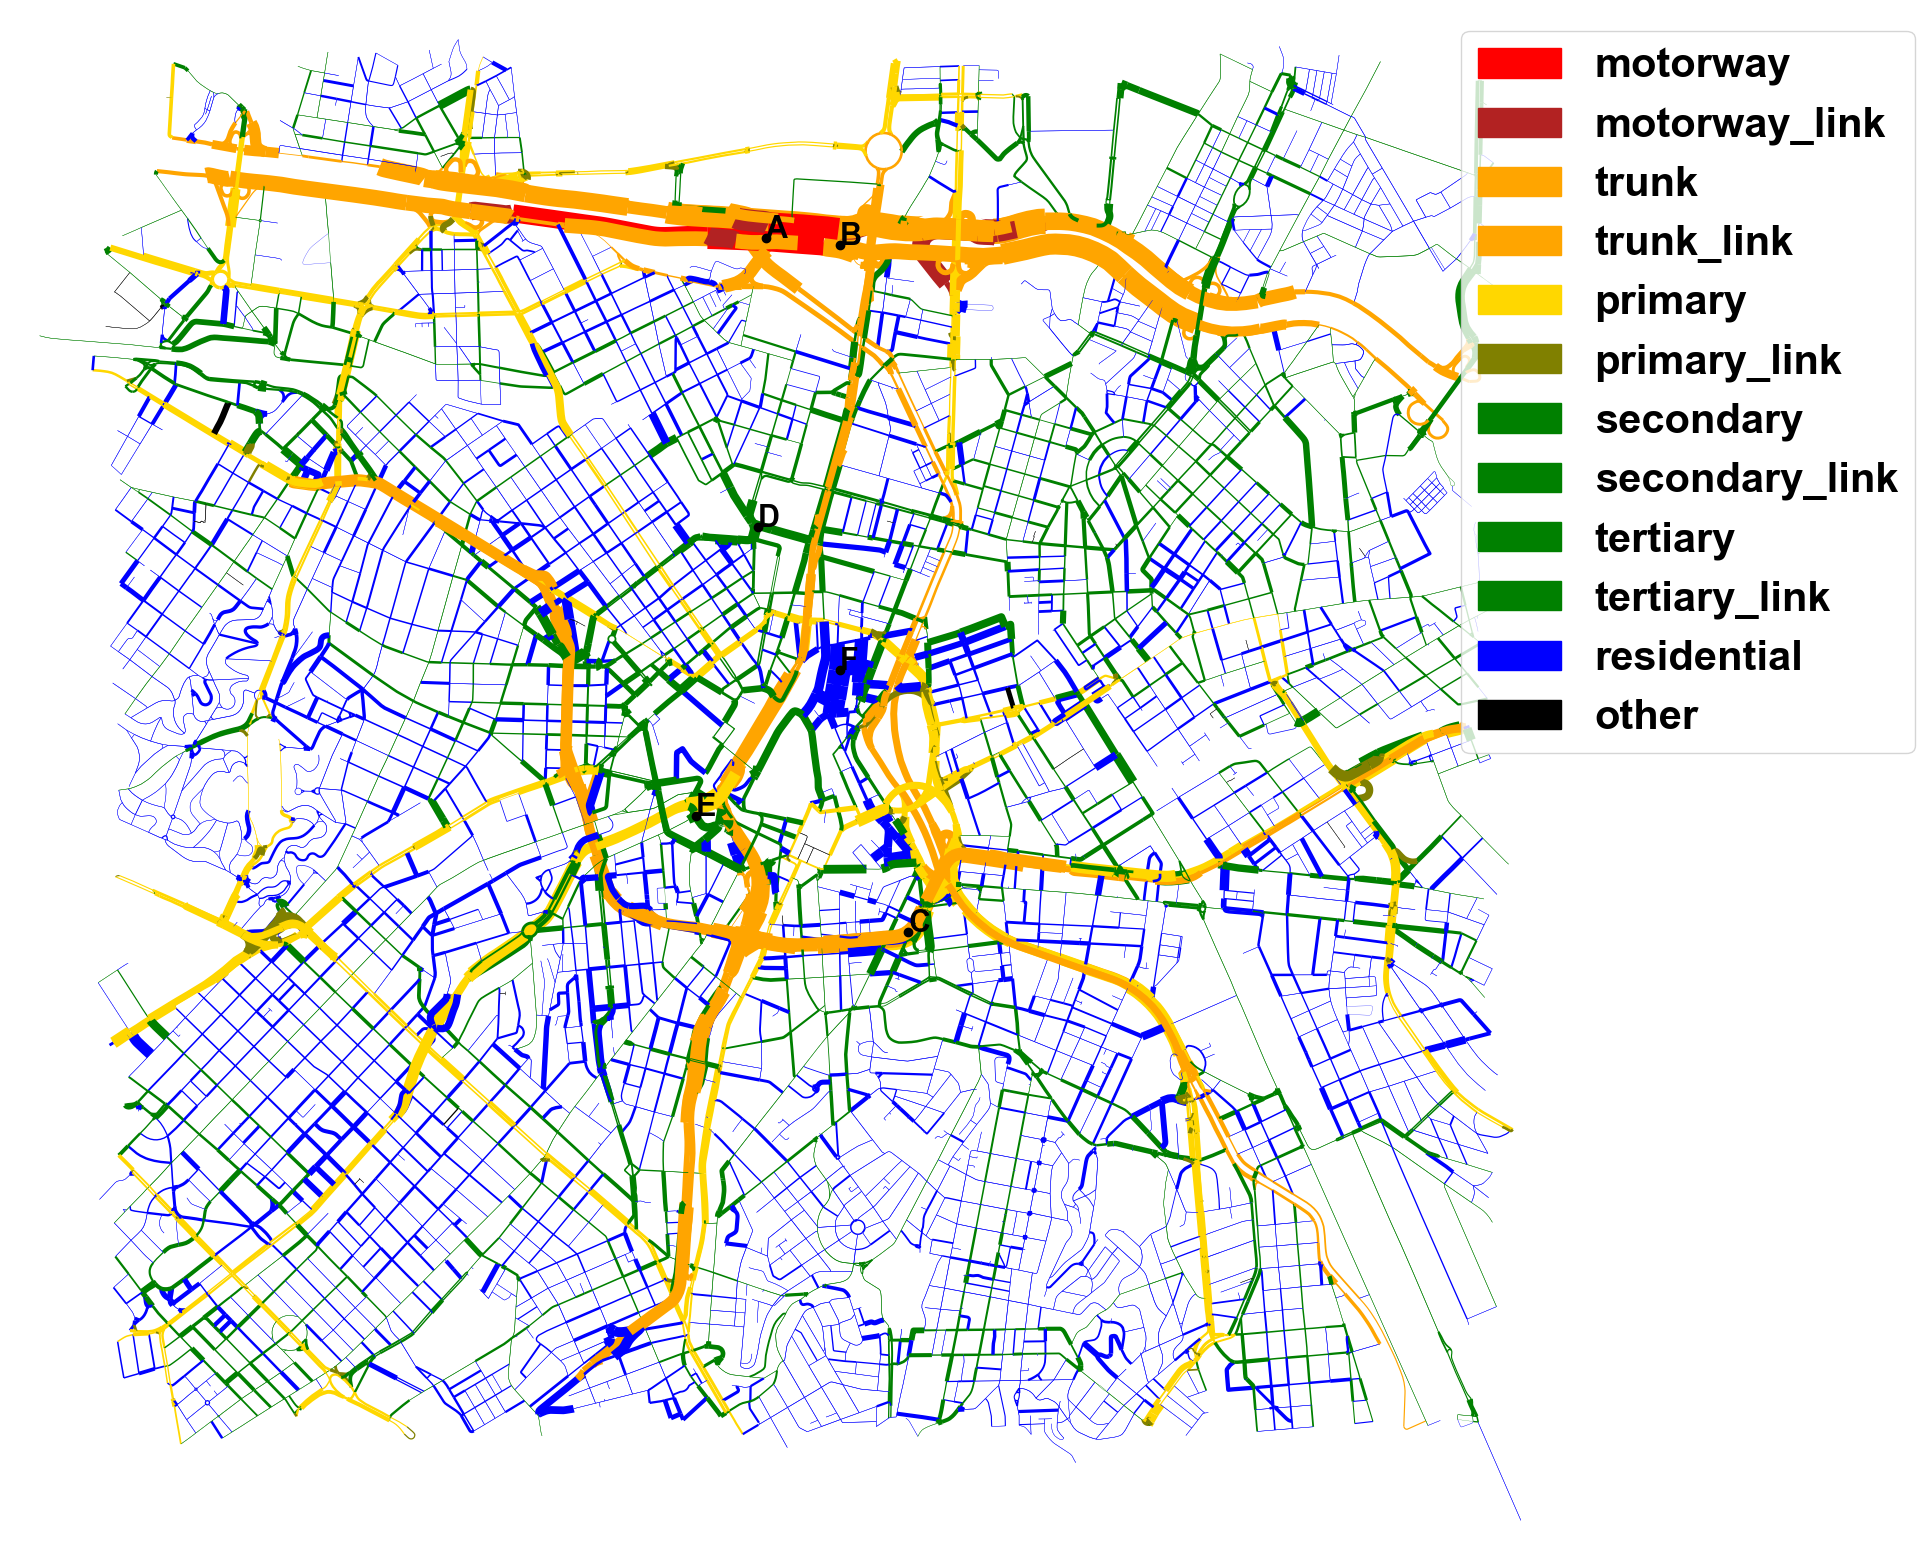

In [13]:
fig, ax = ox.plot_graph(
    H, bgcolor="w", node_color='k', node_size=0, edge_linewidth=edges["Cost of returning"]/max(edges["Cost of returning"])*20, edge_color=ec, figsize = (20,20), show = False, close = False
)
ax.legend(handles = patches, bbox_to_anchor=(1.25, 1), prop = { "size": 30 })

for i,letter in zip(types, letters):
    ax.scatter(df_top_values.loc[i].x,  df_top_values.loc[i].y, color = 'k')
    ax.text(df_top_values.loc[i].x,  df_top_values.loc[i].y, letter) 

fig.savefig(f"Results/{city}_COR_class.png", bbox_inches='tight')

In [14]:
mask = edges.highway.isin([
 'motorway',
 'motorway_link',
 'primary',
 'primary_link',
 'secondary',
 'secondary_link',
 'tertiary',
 'tertiary_link',
 'trunk',
 'trunk_link'])

In [15]:
fig = px.bar(edges.sort_values(by="Cost of returning", ascending=False)["Groups"].head(len(edges)//100).value_counts(normalize=True)*100, title = "Top 1% CoR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,70], title = "Percentage")

fig.update_layout(    font=dict(
        size=25,
        color="black"),
        showlegend=False
        )
fig.write_image(f"Results/{city}_1percent_classes.pdf", width=500, height=1000)
fig

In [16]:
fig = px.bar(edges.sort_values(by="Cost of returning",ascending=False)["Groups"].head(len(edges)//20).value_counts(normalize=True)*100, title = "Top 5% CoR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,70],  title = "Percentage")
fig.update_layout(    font=dict(
        size=25,
        color="black",),
        showlegend=False
        )
fig.write_image(f"Results/{city}_5percent_classes.pdf", width=500, height=1000)

fig

In [17]:
fig = px.bar(edges.sort_values(by="Cost of returning",ascending=False)["Groups"].head(len(edges)//10).value_counts(normalize=True)*100, title = "Top 10% CoR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,70], title = "Percentage")
fig.update_layout(    font=dict(
        size=25,
        color="black",),
        showlegend=False
        )
fig.write_image(f"Results/{city}_10percent_classes.pdf", width=500, height=1000)

fig

### Classes

In [18]:
fig = px.bar(edges[mask].sort_values(by="Cost of returning", ascending=False)["highway"].head(len(edges)//100).value_counts(normalize=True), title = "Top 1% COR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,0.6])

fig.update_layout(    font=dict(
        size=25,
        color="black"
    ))
fig.write_image(f"Results/{city}_masked_1percent_classes.pdf", width=1000, height=1000)
fig

In [19]:
fig = px.bar(edges[mask].sort_values(by="Cost of returning", ascending=False)["highway"].head(len(edges)//20).value_counts(normalize=True), title = "Top 5% COR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,0.6])
fig.update_layout(    font=dict(
        size=25,
        color="black",
    ))
fig.write_image(f"Results/{city}_masked_all_classes.pdf", width=1000, height=1000)

fig

In [20]:
fig = px.bar(edges["highway"].value_counts(normalize=True), title = "Representation of each class")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,0.6])

fig.update_layout(    font=dict(
        size=25,
        color="black"
    ))
fig.write_image(f"Results/{city}_representation_classes.pdf", width=1000, height=1000)

fig

### Tests

In [21]:
# qtd = sum(edges.highway == "residential")//20
qtd = len(edges)//20
# print(qtd)
# qtd = 30
x_points = range(qtd)
# x_points = range(30)
lpoint = []
xs, ys = [], []
for i in x_points:
    # point = edges[edges.highway == "residential"].sort_values(by = "Cost of returning", ascending=False).iloc[i].geometry.centroid
    point = edges.sort_values(by = "Cost of returning", ascending=False).iloc[i].geometry.centroid
    lpoint.append([point.y, point.x])
lpoint = np.array(lpoint)

In [22]:
silhouette_avg = []
max_clusters = 200
min_clusters = 10
for clusters in range(min_clusters,max_clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init="auto").fit(lpoint)
    samples = silhouette_samples(lpoint, kmeans.labels_)
    silhouette_avg.append(silhouette_score(lpoint, kmeans.labels_))



In [23]:
sils = dict(zip(range(min_clusters, max_clusters), silhouette_avg))
# CHs =  dict(zip(range(2, max_clusters), CH_score))
# # print(sils)
# fig, ((ax1, ax2)) = plt.subplots(2, 1)

# ax1.axvline(max(sils, key=sils.get), color="r", linestyle="--")
# ax1.plot(range(min_clusters,max_clusters), silhouette_avg)
# # ax1.set_xlabel("Number of clusters")
# ax1.set_ylabel("Silhouette")

# ax2.plot(range(min_clusters,max_clusters), CH_score)
# ax2.axvline(max(CHs, key=CHs.get), color="r", linestyle="--")
# ax2.set_xlabel("Number of clusters")
# ax2.set_ylabel("CH")
# plt.savefig(f"Novos/{city}_tests.png", bbox_inches = "tight")
# plt.show()
n_clusters = max(sils, key=sils.get)
n_clusters

21

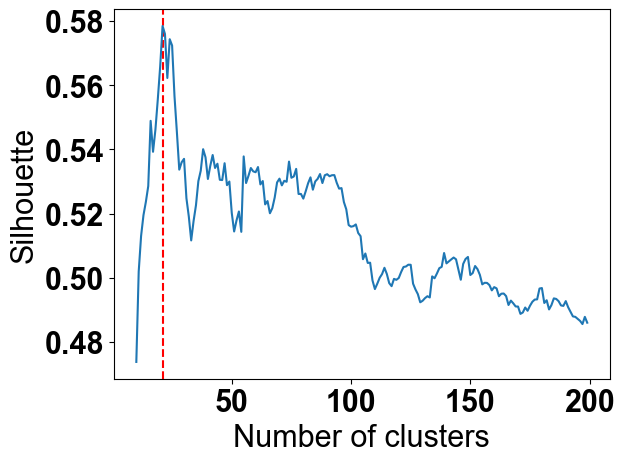

In [24]:
fig, ax1 = plt.subplots(1, 1)

ax1.axvline(max(sils, key=sils.get), color="r", linestyle="--")
ax1.plot(range(min_clusters,max_clusters), silhouette_avg)
# ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Silhouette")    
ax1.set_xlabel("Number of clusters")
plt.savefig(f"Results//{city}_silhouette.pdf", bbox_inches = "tight")
plt.show()

In [25]:
max(sils, key=sils.get)

21

In [26]:
bbox = (nodes.total_bounds[3], nodes.total_bounds[1], nodes.total_bounds[2], nodes.total_bounds[0])

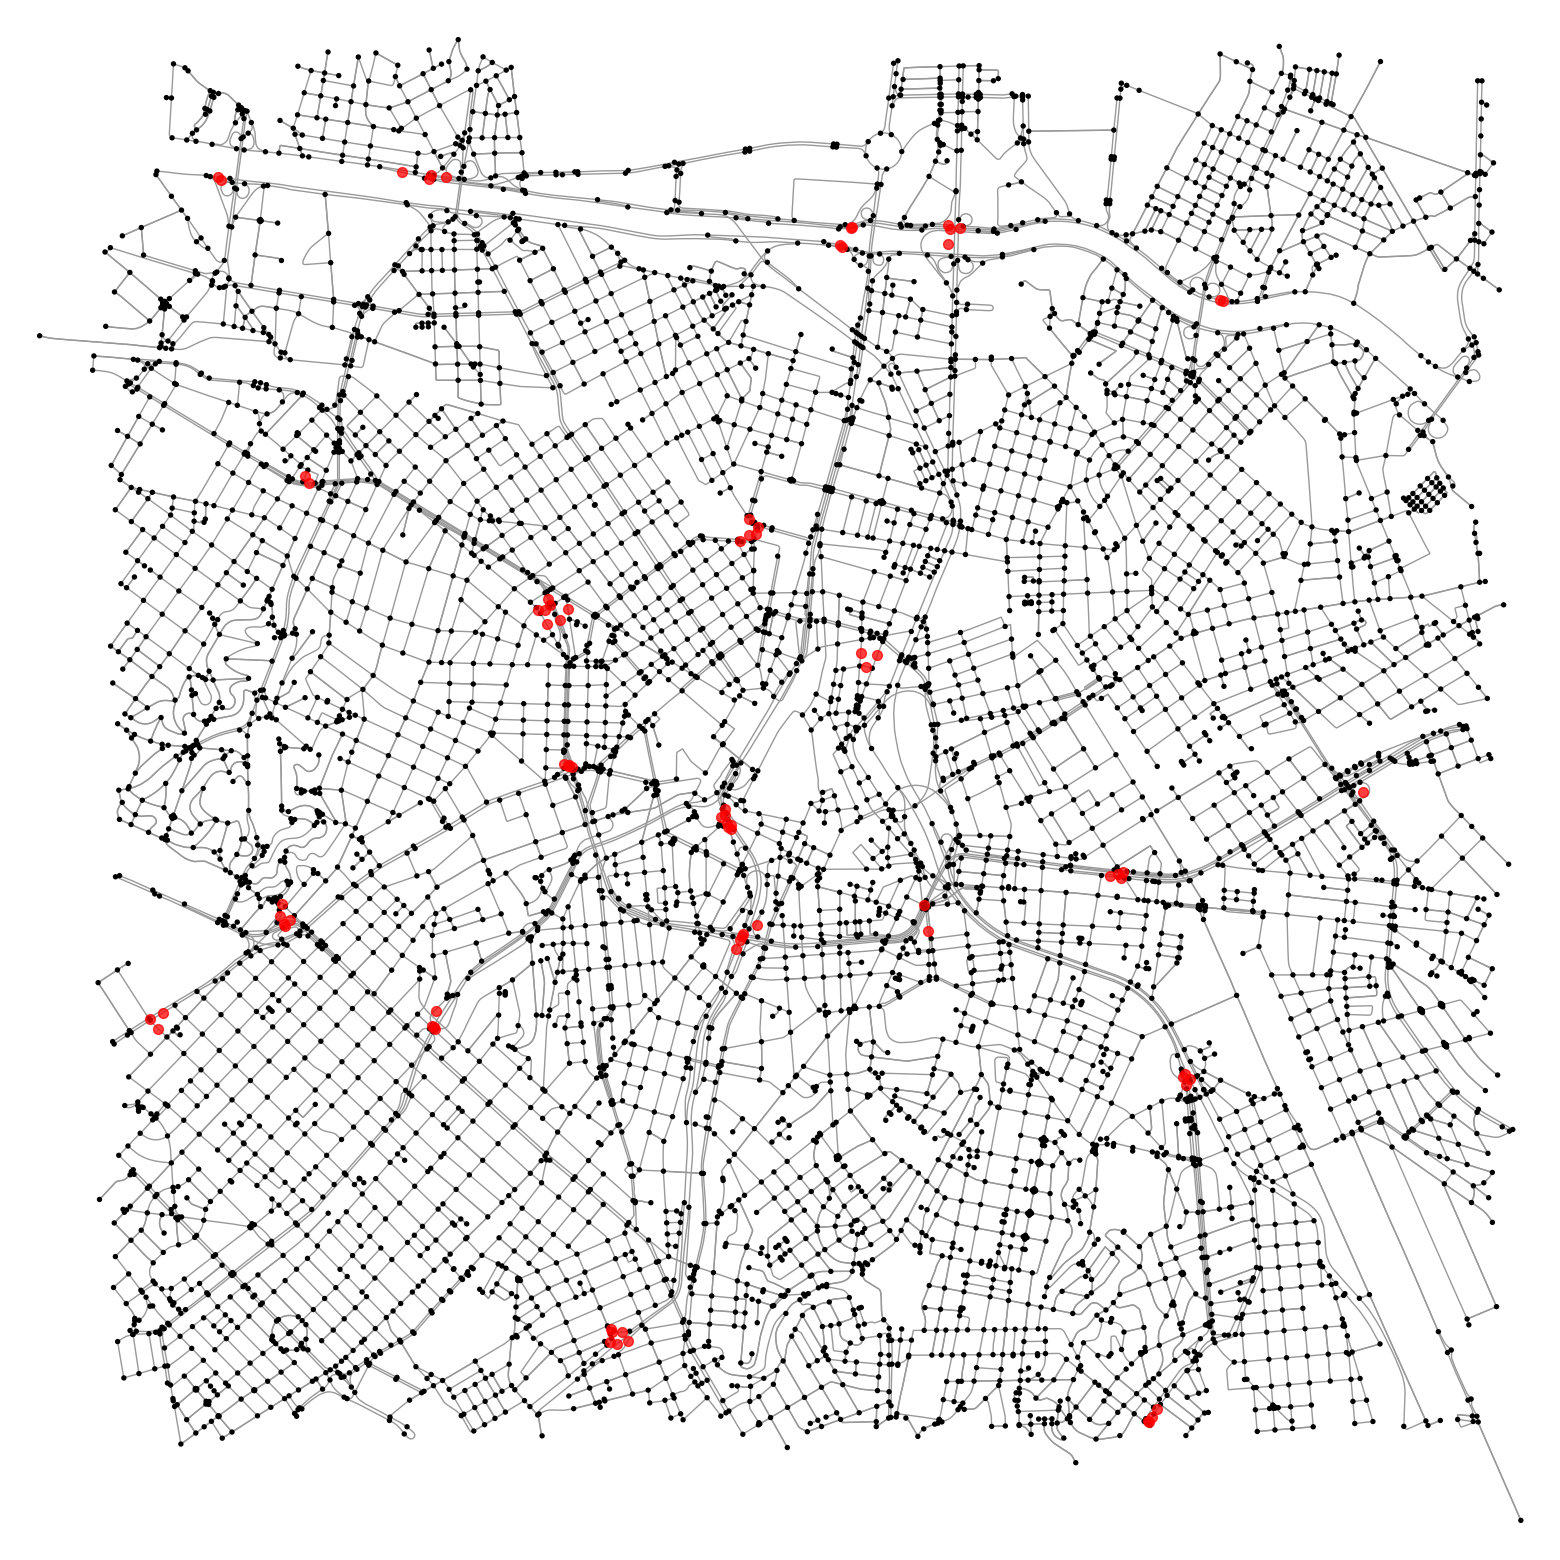

In [27]:
fig, ax = ox.plot_graph(G, close = False, show=False, bgcolor='w', node_color='k', figsize=(20,20))
for i in range(n_clusters):
    idx = kmeans.labels_ == i
    plt.scatter(lpoint[idx, 1], lpoint[idx, 0], color='r', s=50, label=i, alpha=0.75)
plt.savefig(f"Results/{city}_street_positions.png", bbox_inches='tight')
plt.show()

C:\Users\gio-x\AppData\Local\Temp\ipykernel_12804\2799785009.py:49: FutureWarning:

The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\osmnx\plot.py:255: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

C:\Users\gio-x\AppData\Local\Temp\ipykernel_12804\2799785009.py:49: FutureWarning:

The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

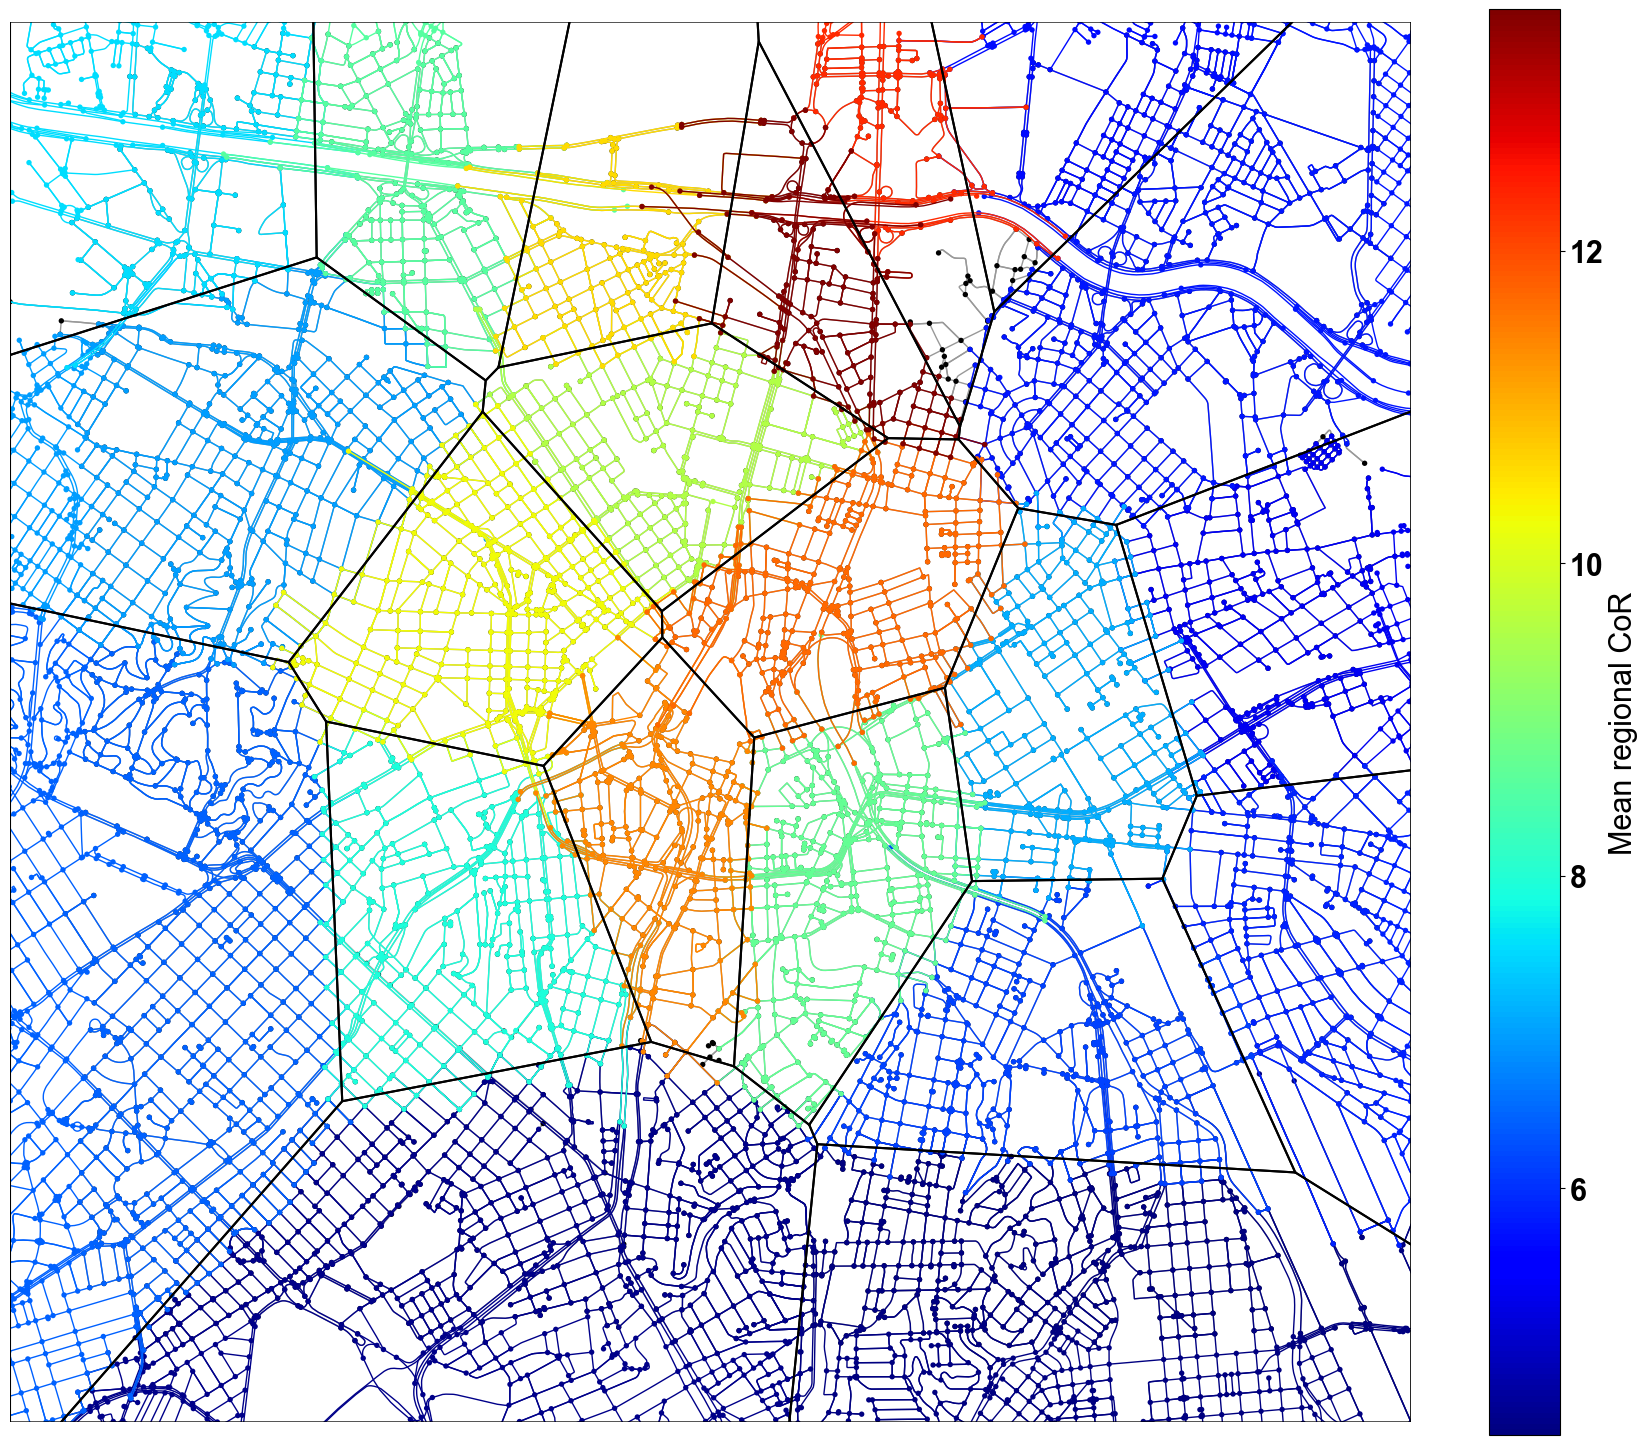

In [41]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(lpoint)
centers = kmeans.cluster_centers_
mean_reg_COR = []
sum_reg_COR = []
reps = []
n_strong_connected = []
fig, ax = ox.plot_graph(G, close = False, show=False, bgcolor='w', node_color='k', figsize=(20,20))
polylist = Voronoi_polys(bbox_bounds=nodes.total_bounds, centers = centers).geometry
# map predictions to label
colors = cycle(cm.tab20.colors)
areas = []
for i in range(n_clusters):
    # clipping = gpd.clip(edges[edges.highway == "residential"], mask = polylist[i])["Cost of returning"]
    clipping = gpd.clip(edges, mask = polylist[i])["Cost of returning"]
    mean_reg_COR.append(clipping.mean())
    sum_reg_COR.append(clipping.sum())

norm = mpl.colors.Normalize(vmin=min(mean_reg_COR), vmax=max(mean_reg_COR))
cmap = cm.jet

m = cm.ScalarMappable(norm=norm, cmap=cmap)
df_regs_cor = pd.DataFrame(zip(polylist, mean_reg_COR), columns= ["Polygons", "Mean Regional CoR"])
df_regs_cor = df_regs_cor.sort_values(by = "Mean Regional CoR").reset_index()

for i in range(n_clusters):
    # plot one cluster for each iteration
    color = m.to_rgba(df_regs_cor["Mean Regional CoR"].iloc[i])
    # find indeces corresponding to cluser i
    idx = kmeans.labels_ == i
    # points_united = list(zip(lpoint[idx, 1],lpoint[idx, 0]))
    # hull = ConvexHull(points_united)

    # for index in hull.vertices: #Indices of points forming the vertices of the convex hull.
        # polylist.append(points_united[index]) #Append this index point to list

    # p = Polygon(polylist)
    # plot cluster
    # K = ox.graph_from_point(centers[i],  dist = dist, truncate_by_edge = True, network_type="drive")
    K = ox.graph_from_polygon(df_regs_cor["Polygons"].iloc[i], "drive", truncate_by_edge=True)


    # bboxfp = ox.utils_geo.bbox_from_point(centers[i], dist)
    # bbox_polygon = bbox_maker(bboxfp[0], bboxfp[1], bboxfp[2], bboxfp[3])
    x,y = polylist[i].exterior.xy
    areas.append(polylist[i].area)
    reps.append(nx.reciprocity(K))
    n_strong_connected.append([len(c) for c in sorted(nx.strongly_connected_components(K), key=len, reverse=True)])
    # color = plt.cm.jet(reps[-1])
    ox.plot_graph(K, ax = ax, node_color = color, edge_color = color, node_alpha=1, edge_alpha = 1, close = False, show = False,  bgcolor='w', figsize=(20,20), bbox =  bbox)
    # plt.scatter(lpoint[idx, 1], lpoint[idx, 0], color=color, s=50, label=i, alpha=0.75)
    # plot center
    # plt.scatter(centers[i, 1], centers[i, 0], edgecolors="k", linewidth=2, color=color, s=100, alpha=1)
    ax.plot(x,y, color = 'k', alpha = 1)
# ax.legend(prop = { "size": 30 }, title = "Group",title_fontsize = 30)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction = 0.046)
cbar.set_label("Mean regional CoR")
plt.savefig(f"Results/{city}_KMEANS_street_positions.pdf", bbox_inches='tight')
plt.show()

In [59]:
sum_COR = np.zeros(n_clusters)
for i in x_points:
    sum_COR[kmeans.labels_[i]] += edges[edges.highway == "residential"].sort_values(by = "Cost of returning", ascending=False).iloc[i]["Cost of returning"]

In [60]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)

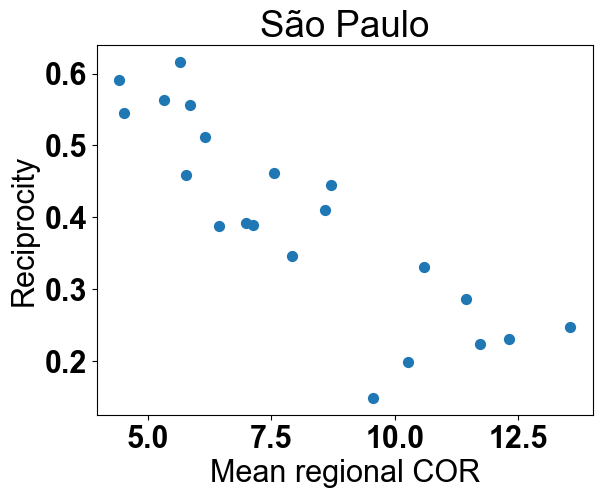

In [67]:
colors = cycle(cm.tab10.colors)
color = next(colors)
fig, ax = plt.subplots()
for i in range(n_clusters):
    # plot one cluster for each iteration
    # find indeces corresponding to cluser i
    # idx = kmeans.labels_ == i
    # plot cluster
    plt.scatter(mean_reg_COR[i], reps[i], color=color, s=50, label=i, alpha=1)
    # plot center
# ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
plt.title(f"{city}")
plt.ylabel("Reciprocity")
plt.xlabel("Mean regional COR")
plt.savefig(f"Results/{city}_reci_meanCOR.pdf", bbox_inches='tight')
plt.show()

# colors = cycle(cm.tab10.colors)
# fig, ax = plt.subplots()
# for i in range(n_clusters):
#     # plot one cluster for each iteration
#     color = next(colors)
#     # find indeces corresponding to cluser i
#     # idx = kmeans.labels_ == i
#     # plot cluster
#     plt.scatter(sum_reg_COR[i], reps[i], color=color, s=50, label=i, alpha=1)
#     # plot center
# ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
# plt.ylabel("Reciprocity")
# plt.title(f"{city}")

# plt.xlabel("Sum of regional COR")
# plt.savefig(f"Novos/{city}_reci_sumCOR.png", bbox_inches='tight')
# plt.show()

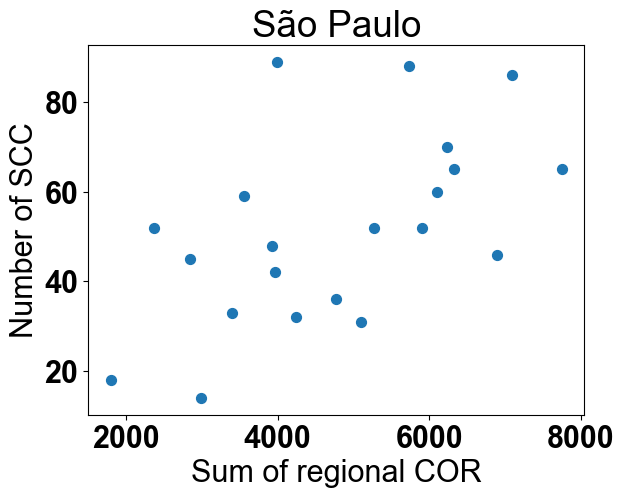

In [62]:
# colors = cycle(cm.tab10.colors)
# fig, ax = plt.subplots()
# y=[len(i) for i in n_strong_connected]
# for i in range(n_clusters):
#     # plot one cluster for each iteration
#     color = next(colors)
#     # find indeces corresponding to cluser i
#     # idx = kmeans.labels_ == i
#     # plot cluster
#     plt.scatter(mean_reg_COR[i], y[i], color=color, s=50, label=i, alpha=1)
#     # plot center
# ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
# plt.ylabel("Number of Strongly connected components")
# plt.title(f"{city}")

# plt.xlabel("Mean regional COR")
# plt.savefig(f"Novos/{city}ncc_meanCOR.png", bbox_inches='tight')
# # plt.legend()
# plt.show()

colors = cycle(cm.tab10.colors)
color = next(colors)
fig, ax = plt.subplots()
y=[len(i) for i in n_strong_connected]
for i in range(n_clusters):
    # plot one cluster for each iteration
    # find indeces corresponding to cluser i
    # idx = kmeans.labels_ == i
    # plot cluster
    plt.scatter(sum_reg_COR[i], y[i], color=color, s=50, label=i, alpha=1)
    # plot center
# ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
plt.ylabel("Number of SCC")
plt.xlabel("Sum of regional COR")
plt.title(f"{city}")

plt.savefig(f"Results/{city}ncc_sumCOR.png", bbox_inches='tight')
# plt.legend()
plt.show()